# Lossy qubitdyne homodyne with compensated tomography

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kstest
from scipy.interpolate import interp1d
import matplotlib as mpl
from tqdm import tqdm
from scipy.integrate import quad
from scipy.special import factorial, eval_hermite, comb
from qutip import *
import cvxpy as cp
import time
from joblib import Parallel, delayed

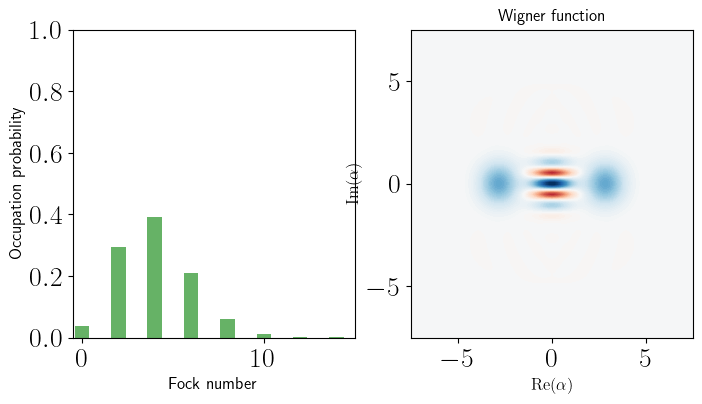

In [2]:
N=15

idc = qeye(N)
ida = qeye(2)
a  = tensor(destroy(N), ida)
sm = tensor(idc, destroy(2))
sx = tensor(idc, sigmax())
sy = tensor(idc, sigmay())
sz = tensor(idc, sigmaz())

# cavity photon number operator
N_cav = tensor(num(N), ida)

# projection operators to qubit ground and excited state
proj0 = tensor(idc, basis(2,0).proj())
proj1 = tensor(idc, basis(2,1).proj())


initial_cavity = coherent(N, 1j*1)


alpha = 2
initial_cavity = (coherent(N, alpha) + coherent(N,-alpha)).unit()

#initial_cavity = fock(N, 3) 


psi0 = tensor(initial_cavity, basis(2,0))
n_init = expect(N_cav, psi0)
plot_wigner_fock_distribution(initial_cavity);

In [3]:
def U_interact(g):
    op = (-1j) * g * (a.dag() * sm + a * sm.dag())
    return op.expm() 

def rotateX(theta):
    op = (-1j) * (theta/2) * sx
    return op.expm()

def rotateY(theta):
    op = (-1j) * (theta/2) * sy
    return op.expm()

def rotateXY(theta,rotangl):
    op = (-1j) * (theta/2) * (np.cos(rotangl)* sx + np.sin(rotangl)* sy)
    return op.expm()

In [4]:
def find_first_zero(func, tol=0.5e-2, max=2000):
    for i in np.arange(max):
        if func(i) < tol:
            return i

## Set measurement parameters

In [ ]:
Ntrajs = 1000 # number of measurement rounds

dt = 0.3 # interaction time

# Time for one measurement round
dt_total = 1

factor = dt_total/dt

# cavity decay rate is set further down.

### Qubitdyne procedure

In [6]:
# seed random state generator
prng = np.random.RandomState(12775425)


qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state

def get_measurements_hist(rotangl, theta, kappa, n_init):
    U_int = U_interact(theta)
    # loss operator
    L = liouvillian(0*a, [np.sqrt(kappa*dt_total)*a])
    op = L.expm()
    
    qbrotmat = rotateXY(np.pi/2,rotangl) # qb rotation applied prior to qb measurement, defines measured homodyne quadrature
    
    quadmeashom = []
    
    def calc_weights(step):
        return (theta/np.sqrt(2))*np.exp(-step*(theta**2/2))

    def pop_time_evol(step):
        return n_init*np.exp(-step*(theta**2))

    # choose number of measurements such that the cavity is nearly emptied
    Nmeas = find_first_zero(pop_time_evol)
    
    calculated_weights = np.array([calc_weights(step) for step in range(Nmeas)])

    for j in tqdm(range(Ntrajs), leave=False):
        xrnd = prng.rand(Nmeas)

        results = []
        psi = ket2dm(psi0)

        for i in range(Nmeas):
            U = qbrotmat * U_int
            psi = U * psi * U.dag()
            prob = expect(proj0,psi)          

            # deterministic loss 
            vec_rho = operator_to_vector(psi)          
            psi = vector_to_operator(op*vec_rho)

            if prob > xrnd[i]:
                # measured g
                #results.append(-1 if error[i] <= correct_prob else 1) 
                results.append(-1)
                psi = (proj0 * psi * proj0).unit()
            else:
                #results.append(1 if error[i] <= correct_prob else -1)
                results.append(1)
                # measured e
                psi = (proj1 * psi * proj1 ).unit()
                # go back to g
                psi = qbfeedback * psi* qbfeedback.dag()
    
        quadmeashom.append(np.sum(results*calculated_weights))

    ### create histogram ###    
    hist, bins = np.histogram(quadmeashom,Nbins,[-k,k], density=True)    

    return hist

### Homodyne settings

In [7]:
nangles = 15
thetas = np.linspace(0,np.pi, nangles) # list of all angles

# histogram parameters
Nbins = 40 # number of histogram bins
k = 5  # bin edge limit
dx =  2*k/Nbins # bin width

## Construct tomography operators

In [8]:
N_large = 30 # need some additional dimensions to properly construct the noise-compensated operators

### Define the harmonic oscillator wavefunction
#To create homodyne POVM operators.

def wavefunction(x,n):
    const = 1/(np.sqrt(2**n * factorial(n)) * (np.pi)**0.25 )
    rest = const* np.exp(-x**2/2)
    return float(rest*eval_hermite(n,x))

### Construct measurement operators
def get_Pis(theta, i):
    Pi = np.zeros((N_large,N_large),dtype=np.complex128)
    for m in range(N_large):
        wave_m = lambda x : wavefunction(x, m)
        for n in range(N_large):
            wave_n = lambda x: wavefunction(x, n)            
            func = lambda x: wave_m(x)*wave_n(x)
            Pi[n,m] = quad(func, -k + i*dx, -k + (i+1)*dx)[0]*np.exp(-1j*(n-m)*theta)
            
    return Pi*2 #

Pis = Parallel(n_jobs=-1, verbose=5, backend="multiprocessing")(delayed(get_Pis)(theta,i) for theta in thetas for i in range(Nbins))

#The list `basis_dms` contains all $\Omega_k$
# funtions to construct vectors
def get_basis_vectors(N_large):
    # construct vectors
    basis_vectors = []
    for i in range(N_large):
        vector = fock(N_large, i)
        basis_vectors.append(np.real(vector.full()))
    
    return basis_vectors
        
def get_basis_dms(N_large, basis_vectors):    
    # construct operators
    basis_dms = []
    for vector1 in basis_vectors:
        for vector2 in basis_vectors:
            dm = np.outer(vector1, vector2)
            basis_dms.append(dm)
            
    return basis_dms

basis_vectors  = get_basis_vectors(N_large) # needed for the adjusted operators
basis_dms = get_basis_dms(N_large, basis_vectors)

basis_vectors_cut = get_basis_vectors(N)
basis_dms_cut = get_basis_dms(N, basis_vectors_cut)

        
### Construct noise adjusted measurement operators
def B(n,k, eta):
    return np.sqrt(comb(n+k,n) * eta**n * (1-eta)**k)

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    9.4s finished


### Determine homodyne detection efficiency

In [9]:
#### EXTERNAL LOSS RATE KAPPA ###########
kappa = 0.002 # <=> T1 = 500 µs

##### EFFECTIVE INTERACTION STRENGTH
theta_int = 0.1*np.pi/2 # 0.1SWAP

gamma = theta_int**2/dt
gamma_effective = gamma/factor 

### Homodyne efficiency
eta = gamma_effective/(gamma_effective + kappa) 


print("eta", eta )

eta 0.9250206502578182


In [10]:
%%time

# get histograms of measurement data
b_all = Parallel(n_jobs=nangles, verbose=1, backend="loky")(delayed(get_measurements_hist)(rotangl,theta_int, kappa, n_init) for rotangl in thetas)

# Load homodyne data into vector $\vec b$
b = np.concatenate([array for array in b_all])

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
                                                   [Parallel(n_jobs=15)]: Done   2 out of  15 | elapsed: 13.0min remaining: 84.6min
100%|█████████▉| 999/1000 [13:36<00:00,  2.82it/s] 

CPU times: user 5.46 s, sys: 1.04 s, total: 6.5 s
Wall time: 13min 39s


                                                   [Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed: 13.7min finished


### Plot one histogram to compare with the ideal distribution from the Wigner marginal

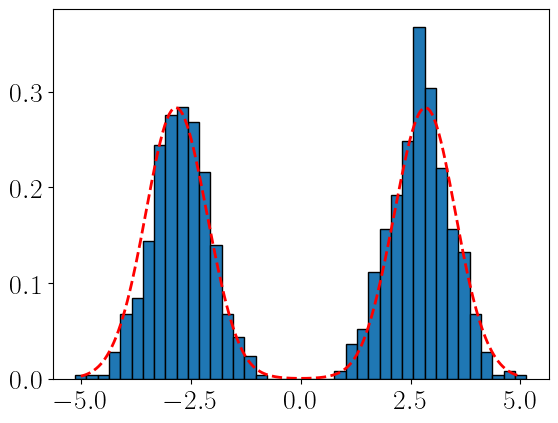

In [16]:
x_hist = np.linspace(-k,k,Nbins)
width = np.diff(x_hist)[3]
histogram = b_all[0]

plt.bar(x_hist,histogram, align='center', width=width, edgecolor='k',label='Samples' );

# ideal distribution from Wigner marginal
x=np.linspace(-k,k,200)
dx = np.diff(x)[0]
W = wigner(initial_cavity, x, x)

marginal = np.trapz(W,x, axis=0) 

# ideal cdf from marginal
cdf = np.cumsum(marginal)*dx
cdf_func = interp1d(x, cdf, fill_value="extrapolate")

plt.plot(x,marginal, 'r--',linewidth=2, label='$W$ marginal');

In [17]:
def get_adjusted_op(i,j,eta):
    op = np.zeros((N_large,N_large), dtype=np.complex64)
    for n in range(N_large):
        for m in range(N_large):
            for k in range(N_large-max(m,n)):
                op += B(m,k,eta)*B(n,k,eta)*Pis[i*Nbins + j][m,n] * np.outer(basis_vectors[n+k], basis_vectors[m+k])#
    return op

op_list = Parallel(n_jobs=-1, verbose=0, backend="multiprocessing")(delayed(get_adjusted_op)(i,j,eta) for i in range(nangles) for j in range(Nbins))        

def func(index, a):
    return np.trace(op_list[index[0]][:N,:N] @ basis_dms_cut[index[1]])

### Construct the matrix A in $A\vec\rho=\vec b$
#From `Pis` and `basis_dms`.
A = np.zeros((len(Pis), N*N), dtype=np.complex64)

A_p = Parallel(n_jobs=-1, verbose=0, backend="multiprocessing")(delayed(func)(idx,a) for idx, a in np.ndenumerate(A))
    
A = np.reshape(A_p, (len(Pis), N*N))

X = cp.Variable((N,N), hermitian=True)

cost = cp.norm(A @ cp.vec(X) - b, 2) 

#Set the trace constraint and positive-semidefinite constraint, respectively.
constraints = [cp.trace(X) == 1, X >> 0 ]

#Set up and solve the problem!

prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(verbose=False, solver='SCS')

# Assign the optimized state X to a Qobj.
reconstructed_rho_comp = Qobj(X.value)

f_comp=fidelity(reconstructed_rho_comp, initial_cavity)**2

### Uncompensated reconstruction

In [19]:
eta_uncomp = 1 

op_list = Parallel(n_jobs=-1, verbose=0, backend="multiprocessing")(delayed(get_adjusted_op)(i,j,eta_uncomp) for i in range(nangles) for j in range(Nbins))        

def func(index, a):
    return np.trace(op_list[index[0]][:N,:N] @ basis_dms_cut[index[1]])

### Construct the matrix A in $A\vec\rho=\vec b$
#From `Pis` and `basis_dms`.
A = np.zeros((len(Pis), N*N), dtype=np.complex64)

A_p = Parallel(n_jobs=-1, verbose=0, backend="multiprocessing")(delayed(func)(idx,a) for idx, a in np.ndenumerate(A))
    
A = np.reshape(A_p, (len(Pis), N*N))

X = cp.Variable((N,N), hermitian=True)

cost = cp.norm(A @ cp.vec(X) - b, 2) 

#Set the trace constraint and positive-semidefinite constraint, respectively.
constraints = [cp.trace(X) == 1, X >> 0 ]

#Set up and solve the problem!

prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(verbose=False, solver='SCS')

# Assign the optimized state X to a Qobj.
reconstructed_rho_uncomp = Qobj(X.value)

f_uncomp=fidelity(reconstructed_rho_uncomp, initial_cavity)**2

## Comparison

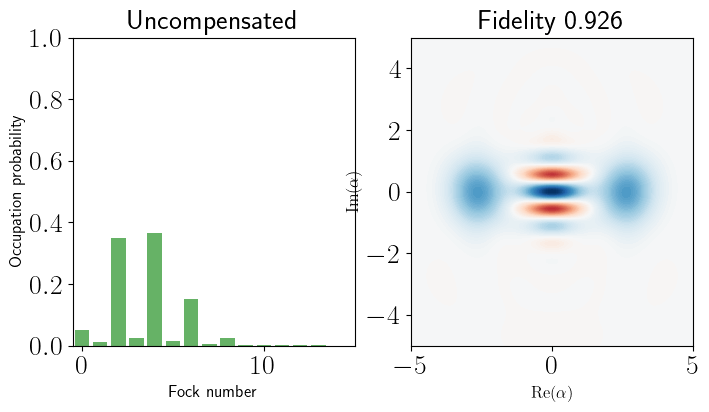

In [20]:
fig, ax = plot_wigner_fock_distribution(reconstructed_rho_uncomp, alpha_max=5)
ax[0].set_title("Uncompensated")

f=fidelity(reconstructed_rho_uncomp, initial_cavity)**2
ax[1].set_title("Fidelity %.3f"%(f_uncomp));

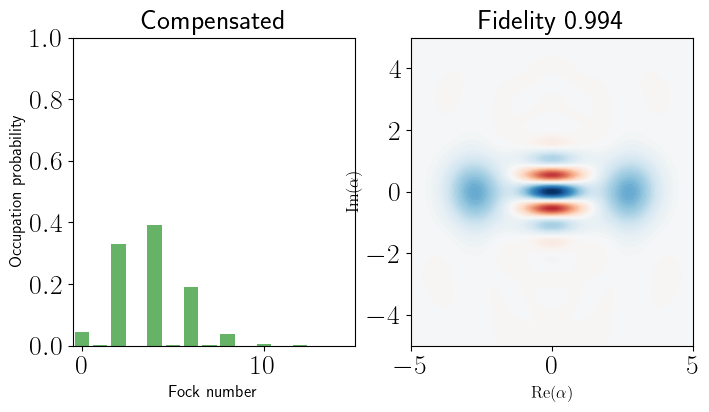

In [21]:
fig, ax = plot_wigner_fock_distribution(reconstructed_rho_comp, alpha_max=5)
ax[0].set_title("Compensated")

f=fidelity(reconstructed_rho_comp, initial_cavity)**2
ax[1].set_title("Fidelity %.3f"%(f_comp));

Higher fidelity with compensated reconstruction.